# car model

Let's start with some basic modeling, now that we actually have some data out of the way.

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
import pandas as pd
from birdcall_distribution.geo import (
    get_shape_us_state,
    generate_grid,
    add_lonlat_columns,
    generate_grid_adjaceny_list,
    CA_EXTENT,
    get_adjacency_mapping,
    convert_to_adjacency_matrix,
)

ee_df = pd.read_parquet("../data/earth_engine_v2.parquet")
grid_size = ee_df.grid_size.values[0]
ca_shape = get_shape_us_state("California")
grid = generate_grid(ca_shape, CA_EXTENT, (grid_size, grid_size))
adjacency_list = generate_grid_adjaceny_list(grid)
mapping = get_adjacency_mapping(adjacency_list)
W = convert_to_adjacency_matrix(adjacency_list)

In [173]:
from birdcall_distribution.utils import convert_time

df = pd.read_csv("../data/raw/birdclef-2022/train_metadata.csv")
df["hour"] = df.time.apply(convert_time)
df = df[["primary_label", "latitude", "longitude", "hour"]].dropna()
df = add_lonlat_columns(df, grid)
df = df[df.grid.notnull()]
df["adjacency_idx"] = df.grid_id.apply(lambda x: mapping.get(x, None))
df

,primary_label,latitude,longitude,hour,grid_id,grid,adjacency_idx
51,amewig,35.0307,-120.6205,9.500000,-121.25_35.0,"POLYGON ((-121.25 35, -120.5 35, -120.5 35.75,...",65
56,amewig,32.5640,-117.1256,9.900000,-117.5_32.0,"POLYGON ((-117.5 32, -116.75 32, -116.75 32.75...",21
57,amewig,32.5640,-117.1256,10.250000,-117.5_32.0,"POLYGON ((-117.5 32, -116.75 32, -116.75 32.75...",21
58,amewig,32.5640,-117.1256,10.883333,-117.5_32.0,"POLYGON ((-117.5 32, -116.75 32, -116.75 32.75...",21
59,amewig,32.5640,-117.1256,10.750000,-117.5_32.0,"POLYGON ((-117.5 32, -116.75 32, -116.75 32.75...",21
...,...,...,...,...,...,...,...
14652,wiltur,33.1349,-116.8522,10.850000,-117.5_32.75,"POLYGON ((-117.5 32.75, -116.75 32.75, -116.75...",22
14655,wiltur,35.2530,-120.8760,14.016667,-121.25_35.0,"POLYGON ((-121.25 35, -120.5 35, -120.5 35.75,...",65
14656,wiltur,32.8706,-116.4247,5.450000,-116.75_32.75,"POLYGON ((-116.75 32.75, -116 32.75, -116 33.5...",15
14660,wiltur,38.5321,-121.0686,5.633333,-121.25_38.0,"POLYGON ((-121.25 38, -120.5 38, -120.5 38.75,...",69


Now let's build our first model. We will create a logistic regression with CAR without any exogenous terms.
Our exogneous factors include landcover (which we will attempt to model as a categorical prior), temperature, and elevation.

In [174]:
# create counts for each adjacency index
import numpy as np
import pymc as pm
import arviz as az

In [177]:
# count number of observed calls per adjacency index, and join against the ee variables

counts_df = df.grid_id.value_counts().reset_index()
counts_df.columns = ["grid_id", "y"]
prep_df = counts_df.merge(
    ee_df.rename(columns={"name": "grid_id"}), on="grid_id", how="outer"
)
prep_df["adjacency_idx"] = prep_df.grid_id.apply(lambda x: mapping.get(x, None))
prep_df = prep_df.set_index("adjacency_idx").sort_index()
prep_df

,grid_id,y,grid_size,total_pixels,elevation_mean,elevation_min,elevation_max,day_temp_mean,day_temp_min,day_temp_max,...,land_cover_08,land_cover_09,land_cover_10,land_cover_11,land_cover_12,land_cover_13,land_cover_14,land_cover_15,land_cover_16,land_cover_17
adjacency_idx,,,,,,,,,,,,,,,,,,,,,
0,-114.5_32.75,4.0,0.75,5799,360.635686,42,1264,38.250063,28.135905,44.101721,...,0.000172,0.000860,0.053473,0.000516,0.019257,0.001204,0.000172,0.000172,0.245873,0.000688
1,-114.5_33.5,4.0,0.75,5810,332.958333,83,1060,38.373284,29.505644,42.446203,...,0.000172,0.000343,0.020079,0.000172,0.053887,0.002917,0.000172,0.000172,0.561009,0.000172
2,-114.5_34.25,15.0,0.75,5660,651.198508,125,2133,35.820667,21.121678,41.516905,...,0.000176,0.003523,0.046503,0.000176,0.000176,0.007574,0.000176,0.000176,0.147261,0.005461
3,-115.25_32.0,14.0,0.75,5797,27.443632,0,153,38.673146,28.443913,44.966025,...,0.000172,0.001204,0.024596,0.000172,0.394737,0.012900,0.000172,0.000172,0.466976,0.000688
4,-115.25_32.75,9.0,0.75,5795,212.048048,9,871,38.502550,31.003916,42.807535,...,0.000172,0.001893,0.041638,0.000172,0.041466,0.001721,0.000172,0.000172,0.755678,0.000344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,-124.25_40.25,24.0,0.75,5235,555.130669,-3,1749,18.493839,12.968095,25.919888,...,0.091584,0.015232,0.042079,0.003237,0.001523,0.009711,0.000190,0.000190,0.000571,0.045887
104,-124.25_41.0,NaN,0.75,5054,523.124211,0,1760,17.261679,10.346703,23.541750,...,0.016565,0.000986,0.002366,0.002761,0.000197,0.000789,0.000197,0.000197,0.000197,0.157365
105,-124.25_41.75,NaN,0.75,5135,685.691752,-3,2002,19.949706,11.934333,27.914494,...,0.067935,0.006599,0.014752,0.000194,0.000776,0.002329,0.000194,0.000194,0.000194,0.019992


In [225]:
[col for col in prep_df.columns if ("mean" in col) or ("land_cover" in col)]

['elevation_mean',
 'day_temp_mean',
 'night_temp_mean',
 'land_cover_01',
 'land_cover_02',
 'land_cover_03',
 'land_cover_04',
 'land_cover_05',
 'land_cover_06',
 'land_cover_07',
 'land_cover_08',
 'land_cover_09',
 'land_cover_10',
 'land_cover_11',
 'land_cover_12',
 'land_cover_13',
 'land_cover_14',
 'land_cover_15',
 'land_cover_16',
 'land_cover_17']

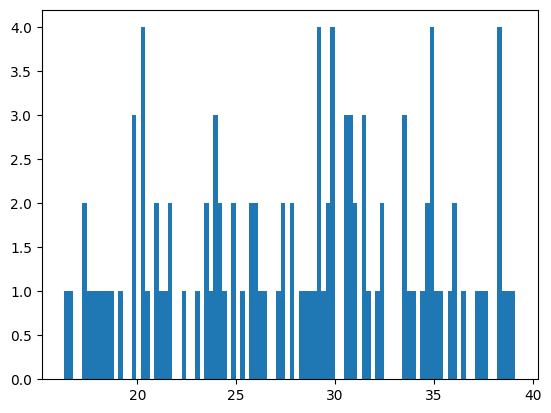

In [222]:
import matplotlib.pyplot as plt

plt.hist(prep_df.day_temp_mean, bins=100)
plt.show()

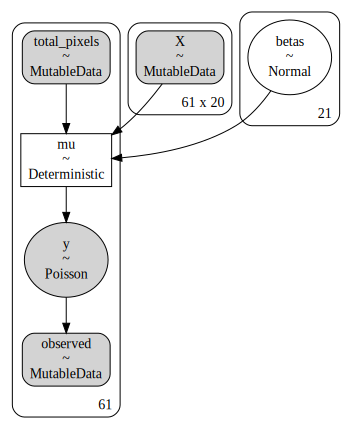

In [235]:
model_df = prep_df[prep_df.y.notnull()]
data_cols = [col for col in prep_df.columns if ("mean" in col) or ("land_cover" in col)]

with pm.Model() as simple_model:
    # create a masked array with observed counts
    observed = pm.MutableData("observed", model_df.y.values)
    total_pixels = pm.MutableData("total_pixels", model_df.total_pixels.values)
    X = pm.MutableData("X", model_df[data_cols].values.astype(np.float64))

    betas = pm.Normal("betas", mu=0, tau=1e-5, shape=X.shape[1] + 1)

    mu = pm.Deterministic(
        "mu",
        pm.math.exp(betas[0] + pm.math.dot(X, betas[1:]) + pm.math.log(total_pixels)),
    )
    pm.Poisson("y", mu=mu, observed=observed)

# draw the model via graphviz
pm.model_to_graphviz(simple_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [betas]


Sampling 8 chains for 2_000 tune and 2_000 draw iterations (16_000 + 16_000 draws total) took 299 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6252, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.997, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],-64.656,80.033,-218.338,0.992,24.267,17.641,11.0,61.0,2.54
betas[1],-0.105,0.144,-0.292,0.041,0.051,0.037,9.0,8.0,3.34
betas[2],0.055,0.432,-0.425,0.776,0.152,0.112,9.0,8.0,3.33
betas[3],0.098,0.371,-0.708,0.562,0.130,0.096,9.0,10.0,3.22
betas[4],67.078,81.955,-0.783,221.718,25.050,18.219,11.0,34.0,2.58
betas[5],52.266,70.421,-6.077,203.334,20.203,14.643,13.0,10.0,2.45
betas[6],-245.042,305.369,-838.055,0.745,86.778,62.868,12.0,56.0,2.31
betas[7],-437.920,443.555,-998.368,0.620,154.606,113.449,10.0,23.0,2.39
betas[8],157.252,165.179,-0.904,397.025,56.259,41.211,9.0,10.0,2.60
betas[9],65.180,80.303,-0.476,218.951,24.374,17.720,11.0,9.0,2.58


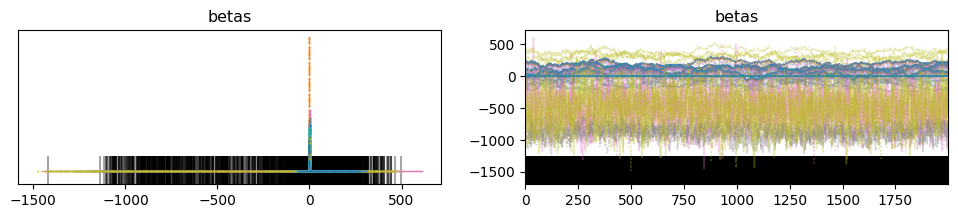

In [236]:
with simple_model:
    trace = pm.sample(2000, tune=2000, cores=8, target_accept=0.9, tree_depth=15)

az.plot_trace(trace, var_names=["betas"])
az.summary(trace, var_names=["betas"])

In [238]:
with simple_model:
    pm.set_data(
        {
            "total_pixels": prep_df.total_pixels.values,
            "X": prep_df[data_cols].values.astype(np.float64),
        }
    )
    ppc = pm.sample_posterior_predictive(trace, predictions=True)

Sampling: [betas, y]


ValueError: lam value too large
Apply node that caused the error: poisson_rv{0, (0,), int64, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FDB09518E40>), MakeVector{dtype='int64'}.0, TensorConstant{4}, mu)
Toposort index: 12
Inputs types: [RandomGeneratorType, TensorType(int64, (1,)), TensorType(int64, ()), TensorType(float64, (None,))]
Inputs shapes: ['No shapes', (1,), (), (108,)]
Inputs strides: ['No strides', (8,), (), (8,)]
Inputs values: [Generator(PCG64) at 0x7FDB09518E40, array([61]), array(4), 'not shown']
Outputs clients: [['output'], ['output']]

HINT: Re-running with most Aesara optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the Aesara flag 'optimizer=fast_compile'. If that does not work, Aesara optimizations can be disabled with 'optimizer=None'.
HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
with pm.Model() as car_model:
    # create a masked array with observed counts
    observed = pm.MutableData("observed", model_df.y.values)
    adjacency_idx = pm.MutableData("adjacency_idx", model_df.index.values)
    total_pixels = pm.MutableData("total_pixels", model_df.total_pixels.values)
    X = pm.MutableData("X", model_df[data_cols].values.astype(np.float64))

    betas = pm.Normal("betas", mu=0, tau=1e-5, shape=X.shape[1] + 1)

    # spatial adjustments, random effects
    alpha = pm.Uniform("alpha", 0, 1)
    phi = pm.CAR("phi", mu=np.zeros(W.shape[0]), tau=1e-5, alpha=alpha, W=W)

    mu = pm.Deterministic(
        "mu",
        pm.math.exp(
            betas[0]
            + pm.math.dot(X, betas[1:])
            + phi[adjacency_idx]
            + pm.math.log(total_pixels)
        ),
    )
    pm.Poisson("y", mu=mu, observed=observed)

# draw the model via graphviz
pm.model_to_graphviz(car_model)

In [ ]:
with simple_model:
    trace = pm.sample(2000, tune=2000, cores=8, target_accept=0.9, tree_depth=15)

az.plot_trace(trace, var_names=["betas", "phi"])
az.summary(trace, var_names=["betas", "phi"])